In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

In [3]:
class Network:
    """
    A class to hold the queueing network object
    """
    def __init__(self, n1, n2, mu1, mu2, r11, r12, r21, r22, L1, L2):
        self.n1 = n1
        self.n2 = n2
        self.mu1 = mu1
        self.mu2 = mu2
        self.r11 = r11
        self.r12 = r12
        self.r21 = r21
        self.r22 = r22
        self.L1 = L1
        self.L2 = L2
        self.State_Space = [(i, j) for i in range(self.n1+3) for j in range(self.n2+3) if i+j<=self.n1+self.n2+2] + [-1, -2, -3]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        if state1 in [-1, -2, -3]:
            return 0
        if state2 == -3:
            if state1[0] == self.n1 and state1[1] == self.n2 + 2:
                return self.r21 * self.mu2
            if state1[0] == self.n1 + 2 and state1[1] == self.n2:
                return self.r12 * self.mu1
            else:
                return 0
        elif state2 == -1:
            if state1[0] >= self.n1+1 and state1[1] < self.n2+2:
                return self.r11*self.mu1
            else:
                return 0
        elif state2 == -2:
            if state1[1] >= self.n2+1 and state1[0] < self.n1+2:
                return self.r22*self.mu2
            else:
                return 0
        else:
            delta = (state2[0] - state1[0], state2[1] - state1[1])
            if delta == (1, 0):
                if state1[0] < self.n1 + 1:
                    return self.L1
                return 0
            if delta == (0, 1):
                if state1[1] < self.n2 + 1:
                    return self.L2
                return 0
            if delta == (-1, 0):
                if state1[1] < self.n2 + 2:
                    return (1 - self.r12 - self.r11) * self.mu1
                return 0
            if delta == (0, -1):
                if state1[0] < self.n1 + 2:
                    return (1 - self.r21 - self.r22) * self.mu2
                return 0
            if delta == (-1, 1):
                if state1[1] < self.n2 + 2 and (state1[0], state1[1]) != (self.n1+2, self.n2):
                # if state1[1] < self.n2 + 2:
                    return self.r12 * self.mu1
                return 0
            if delta == (1, -1):
                if state1[0] < self.n1 + 2 and (state1[0], state1[1]) != (self.n1, self.n2+2):
                # if state1[0] < self.n1 + 2:
                    return self.r21 * self.mu2
                return 0
            return 0

    def write_transition_matrix(self):
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)

    def discretise_transition_matrix(self):
        self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))

    def find_mean_time_to_absorbtion(self):
        T = self.discrete_transition_matrix[:-3, :-3]
        S = np.linalg.inv(np.identity(len(T)) - T)
        steps2absorb = [sum([S[i,j] for j in range(len(S))]) for i in range(len(S))]
        time2absorb = [s*self.time_step for s in steps2absorb]
        self.mean_steps_to_absorbtion = {str(self.State_Space[i]): steps2absorb[i] for i in range(len(steps2absorb))}
        self.mean_time_to_absorbtion = {str(self.State_Space[i]): float(time2absorb[i]) for i in range(len(time2absorb))}

    def write_results_to_file(self, param):
        results_file = open('%stheoretical_results_%s.yml' % (directory, str(param)), 'w')
        results_file.write(yaml.dump(self.mean_time_to_absorbtion, default_flow_style=False))
        results_file.close()

    def find_absorpion_probabilities(self):
        T = self.discrete_transition_matrix[:-3, :-3]
        S = np.linalg.inv(np.identity(len(T)) - T)
        B = self.discrete_transition_matrix[:-3,-3:]
        A = np.matrix(S)*np.matrix(B)
        self.absorbtion_probabilities = {str(self.State_Space[i]): [A[0,j] for j in range(3)] for i in range(len(A))}

    def write_absorb_results_to_file(self, param):
        results_file = open('%sabsorbtion_probabilities_%s.yml' % (directory, str(param)), 'w')
        results_file.write(yaml.dump(self.absorbtion_probabilities, default_flow_style=False))
        results_file.close()

In [40]:
def plot_heatmap(n1, n2, r11, r12, r21, r22, L1, L2, name):
    ticks = [round((i*0.2 - 4.0), 2) for i in range(41)]
    mus = [10**i for i in ticks]
    ttd = []
    for mu1 in mus:
        ttd.append([])
        for mu2 in mus:
            Q = Network(n1, n2, mu1, mu2, r11, r12, r21, r22, L1, L2)
            Q.find_mean_time_to_absorbtion()
            ttd[-1].append(Q.mean_time_to_absorbtion['(0, 0)'])
    x = ticks
    y = ticks
    ticksshow = [r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$']
    X,Y = np.meshgrid(x, y)
    plt.imshow(ttd, origin='lower', norm=mpl.colors.LogNorm(), cmap='viridis_r')
    plt.xticks([ticks.index(i) for i in [-4, -3, -2, -1, 0, 1, 2, 3, 4]], ticksshow)
    plt.yticks([ticks.index(i) for i in [-4, -3, -2, -1, 0, 1, 2, 3, 4]], ticksshow)
    plt.xlabel(r"$\mu_2$", fontsize=16)
    plt.ylabel(r"$\mu_1$", fontsize=16, rotation=0)
    plt.colorbar().set_label(label=r"$\omega$", size=16, rotation=0)
    plt.savefig(name)
    plt.show()

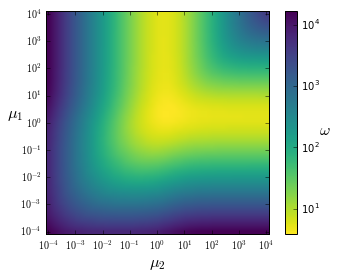

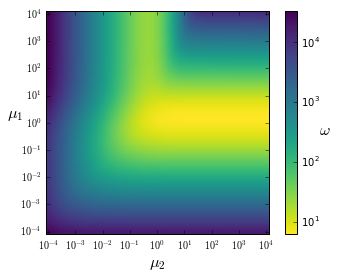

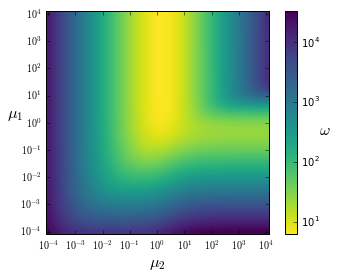

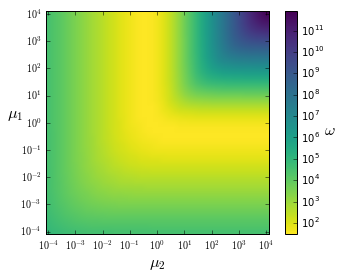

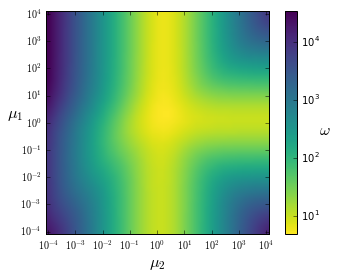

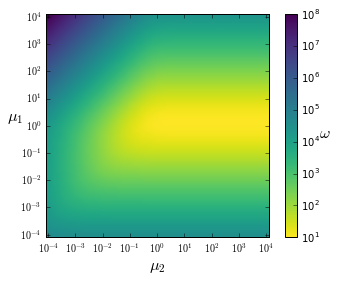

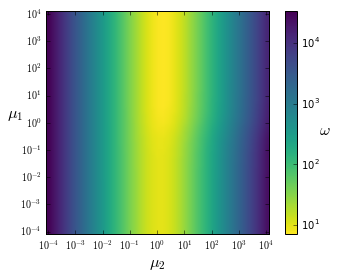

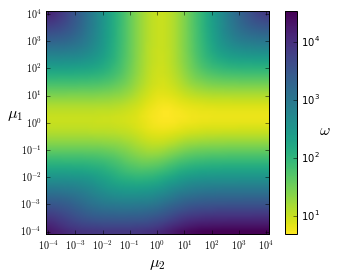

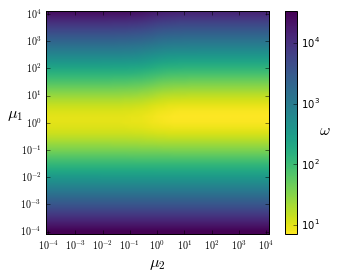

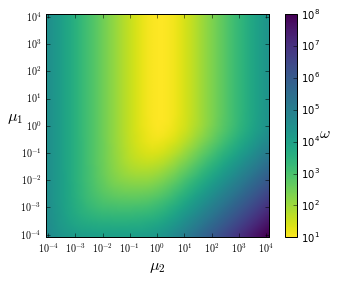

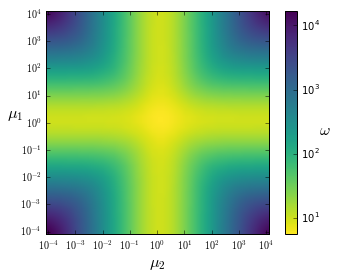

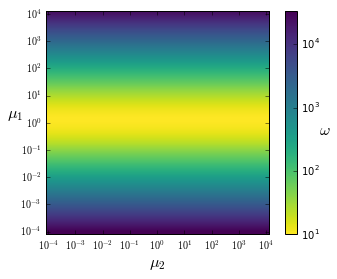

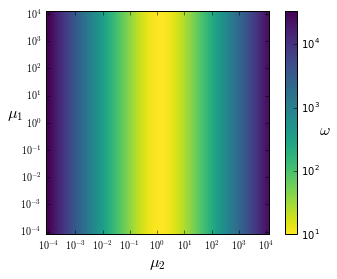

In [41]:
n1, n2 = 1, 1
r11, r12, r21, r22 = 0.3, 0.3, 0.3, 0.3
L1, L2 = 1, 1
plot_heatmap(n1, n2, r11, r12, r21, r22, L1, L2, 'r11r12r21r22.pdf')
plot_heatmap(n1, n2, r11, r12, r21, 0.0, L1, L2, 'r11r12r21.pdf')
plot_heatmap(n1, n2, 0.0, r12, r21, r22, L1, L2, 'r12r21r22.pdf')
plot_heatmap(n1, n2, 0.0, r12, r21, 0.0, L1, L2, 'r12r21.pdf')
plot_heatmap(n1, n2, r11, r12, 0.0, r22, L1, L2, 'r11r12r22.pdf')
plot_heatmap(n1, n2, r11, r12, 0.0, 0.0, L1, L2, 'r11r12.pdf')
plot_heatmap(n1, n2, 0.0, r12, 0.0, r22, L1, L2, 'r12r22.pdf')
plot_heatmap(n1, n2, r11, 0.0, r21, r22, L1, L2, 'r11r21r22.pdf')
plot_heatmap(n1, n2, r11, 0.0, r21, 0.0, L1, L2, 'r11r21.pdf')
plot_heatmap(n1, n2, 0.0, 0.0, r21, r22, L1, L2, 'r21r22.pdf')
plot_heatmap(n1, n2, r11, 0.0, 0.0, r22, L1, L2, 'r11r22.pdf')
plot_heatmap(n1, n2, r11, 0.0, 0.0, 0.0, L1, L2, 'r11.pdf')
plot_heatmap(n1, n2, 0.0, 0.0, 0.0, r22, L1, L2, 'r22.pdf')

In [5]:
def make_hm(params):
    n1, n2, r11, r12, r21, r22, L1, L2 = params
    ticks = [round((i*0.2 - 4.0), 2) for i in range(41)]
    mus = [10**i for i in ticks]
    ttd = []
    for mu1 in mus:
        ttd.append([])
        for mu2 in mus:
            Q = Network(n1, n2, mu1, mu2, r11, r12, r21, r22, L1, L2)
            Q.find_mean_time_to_absorbtion()
            ttd[-1].append(Q.mean_time_to_absorbtion['(0, 0)'])
    return ttd

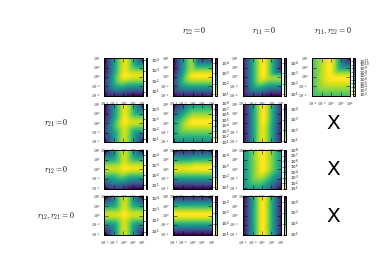

In [36]:
n1, n2 = 1, 1
r11, r12, r21, r22 = 0.3, 0.3, 0.3, 0.3
L1, L2 = 1, 1

ticks = [round((i*0.2 - 4.0), 2) for i in range(41)]
ticksshow = [r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$', r'$10^{2}$', r'$10^{4}$']



inputs = {(1, 1):(n1, n2, r11, r12, r21, r22, L1, L2),
          (1, 2):(n1, n2, r11, r12, r21, 0.0, L1, L2),
          (1, 3):(n1, n2, 0.0, r12, r21, r22, L1, L2),
          (1, 4):(n1, n2, 0.0, r12, r21, 0.0, L1, L2),
          (2, 1):(n1, n2, r11, r12, 0.0, r22, L1, L2),
          (2, 2):(n1, n2, r11, r12, 0.0, 0.0, L1, L2),
          (2, 3):(n1, n2, 0.0, r12, 0.0, r22, L1, L2),
          (3, 1):(n1, n2, r11, 0.0, r21, r22, L1, L2),
          (3, 2):(n1, n2, r11, 0.0, r21, 0.0, L1, L2),
          (3, 3):(n1, n2, 0.0, 0.0, r21, r22, L1, L2),
          (4, 1):(n1, n2, r11, 0.0, 0.0, r22, L1, L2),
          (4, 2):(n1, n2, r11, 0.0, 0.0, 0.0, L1, L2),
          (4, 3):(n1, n2, 0.0, 0.0, 0.0, r22, L1, L2)}

hms = {ks: make_hm(list(inputs[ks])) for ks in inputs.keys()}


f, axarr = plt.subplots(5, 5)

for coords in inputs.keys():
    im = axarr[coords].imshow(hms[coords], origin='lower', norm=mpl.colors.LogNorm(), cmap='viridis_r')
    axarr[coords].set_xticks([ticks.index(i) for i in [-4, -2, 0, 2, 4]])
    axarr[coords].set_yticks([ticks.index(i) for i in [-4, -2, 0, 2, 4]])
    axarr[coords].tick_params(labelsize=4)
    axarr[coords].set_xticklabels(ticksshow)
    axarr[coords].set_yticklabels(ticksshow)
    cbar = plt.colorbar(im, ax=axarr[coords])
    cbar.ax.tick_params(labelsize=4)
axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
# axarr[0, 1].text(0.5, 0.5, r'$r_{11}$' + ' = 0.3\n' + r'$r_{22}$' + ' = 0.3', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[0, 2].axis('off')
axarr[0, 2].text(0.5, 0.5, r'$r_{22} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[0, 3].axis('off')
axarr[0, 3].text(0.5, 0.5, r'$r_{11} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[0, 4].axis('off')
axarr[0, 4].text(0.5, 0.5, r'$r_{11}, r_{22} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[1, 0].axis('off')
# axarr[1, 0].text(0.5, 0.5, r'$r_{12}$' + ' = 0.3\n' + r'$r_{21}$' + ' = 0.3', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[2, 0].axis('off')
axarr[2, 0].text(0.5, 0.5, r'$r_{21} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[3, 0].axis('off')
axarr[3, 0].text(0.5, 0.5, r'$r_{12} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)
axarr[4, 0].axis('off')
axarr[4, 0].text(0.5, 0.5, r'$r_{12}, r_{21} = 0$', horizontalalignment='center', verticalalignment='center', fontsize=8)

axarr[2, 4].axis('off')
axarr[2, 4].text(0.5, 0.5, 'X', horizontalalignment='center', verticalalignment='center', fontsize=20)
axarr[3, 4].axis('off')
axarr[3, 4].text(0.5, 0.5, 'X', horizontalalignment='center', verticalalignment='center', fontsize=20)
axarr[4, 4].axis('off')
axarr[4, 4].text(0.5, 0.5, 'X', horizontalalignment='center', verticalalignment='center', fontsize=20)
# plt.tight_layout()
plt.savefig('test.pdf')